# Import Data & Packages

In [1]:
import pandas as pd
import numpy as np
import datetime
from ast import literal_eval
import konlpy
from collections import Counter
import time
import networkx as nx
import matplotlib.pyplot as plt
import re
import torch
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from datetime import datetime
import copy
import pickle
from tqdm import tqdm

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df_whole=pd.read_json('amore_data_detected_bert.json')
df_whole['review_split_string']=df_whole['review_split'].copy()
df_whole['review_split']=df_whole['review_split_string'].apply(literal_eval)

In [3]:
with open('product_smallcategory_dict.pkl', 'rb') as handle:
    prod_small_dict = pickle.load(handle)

# Functions

## `NVA` 
- Noun / Verb / Adjective를 뽑아내는 함수

In [4]:
def NVA(x):    
    total_words=[]
    for i, document in enumerate(list(set(x))):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True): 
            if word[1] in ['Noun', 'Verb', 'Adjective']: 
                clean_words.append(word[0])
        total_words.append(clean_words)

    result = []
    for x in total_words:
        result.extend(x)
    return result

## `replace_multiple_strings` 
- 리뷰 내 '특정 단어 리스트'들을 '특정 단어'로 바꾸기

In [5]:
def replace_multiple_strings(from_list,to_string,df,colname):
    for string in from_list:
        df[colname]=df[colname].str.replace(string,to_string)
    return df_whole

## `get_current_k`
- 특정 날짜로부터, 과거 K window만큼의 기간에만 해당하는 데이터 필터링

In [6]:
def get_current_k (df, Y, M, D, K = 60 ):
    import datetime
    eval_date = datetime.datetime(Y,M,D)
    from_date = eval_date - datetime.timedelta(days = K )
    df =  df[ (df['date'] >= from_date)&(df['date'] < eval_date)]
    return eval_date, df

## `fill_mtl_output`
- 사전 학습된 MTL 모델을 통해, 감정 예측하는 함수

In [7]:
def softmax(x):
    return (torch.exp(x) / torch.exp(x).sum()).flatten()

def fill_mtl_output(model, df):
    #------------------------------------------------------------------------------------#
    MTL_cols=["overall({})".format(i) for i in [0,0.5,1]]+[c + '(0)' for c in cols1]+[c + '(0.5)' for c in cols1]+[c + '(1)' for c in cols1]+['ATT_'+c for c in cols1]
    MTL_output=pd.DataFrame(index=df.index,columns=MTL_cols)
    
    #------------------------------------------------------------------------------------#
    for ind in tqdm(df.index):
        review = torch.FloatTensor( df['embed_sents'][ind])
        num_sents = torch.tensor( len(review) )
        small_task= cat_task[ df['category'][ind] ]
        detect = df['mask'][ind]
        deteted_aspect= df.loc[ind,cols2][ df.loc[ind,cols2] == 1 ].index.values.tolist()
        deteted_aspect_ind = np.array( small_cat_indices[ small_task - 1 ] )[detect].tolist()
        deteted_aspect_target = np.array(cols1)[deteted_aspect_ind].tolist()
        model.eval()
        model.to('cpu')
        with torch.no_grad():
            out = model(review.unsqueeze(0), num_sents.unsqueeze(0))
        tg, ts, a1, a2, a3, a4, a5, a_g = out
        att_a = [a1[:3], a1[3:6],a1[6:], a2, a3, a4[:3], a4[4:], a5[:3], a5[3:]]
        overall_pred = dict( zip( ['5', '4', '1~3'], list(softmax(tg[small_task-1] )[[2,1,0]].data.numpy().round(3)) ) )

        MTL_output.loc[ind,['overall(1)','overall(0.5)','overall(0)']]=list(overall_pred.values())

        calibrated_imp = a_g[small_task-1].flatten()[[df['mask'][ind]]].numpy() / sum(a_g[small_task-1].flatten()[[df['mask'][ind]]].numpy() )
        aspect_imps = dict( zip( deteted_aspect_target, calibrated_imp) )

        for id_, (aspect_ind, aspect_name,aspect_imp) in enumerate(zip(deteted_aspect_ind, deteted_aspect_target,aspect_imps.values())):
            a_index = np.where( (np.array(small_cat_indices[small_task-1]) == aspect_ind))[0][0]
            aspect_pred = dict(zip(['1','0.5', '0'], list(softmax(ts[small_task-1][a_index] )[[2,1,0]].data.numpy().round(3)) ))
            MTL_output.loc[ind,aspect_name + '(1)']=aspect_pred['1']
            MTL_output.loc[ind,aspect_name + '(0.5)']=aspect_pred['0.5']
            MTL_output.loc[ind,aspect_name + '(0)']=aspect_pred['0']
            MTL_output.loc[ind,'ATT_'+aspect_name]=aspect_imp
    
    #------------------------------------------------------------------------------------#
    df = pd.concat([df,MTL_output],axis=1)
    return df


# Data Preprocess

1) `NVA` 뽑아내기
- `'df_whole.csv'`로 따로 저장하기

In [46]:
df_whole['nva']=df_whole['review_split'].apply(NVA)

2) 기타 전처리
- `small_category` : 소제품군 column 추가
- `prod_nm_origin` vs `prod_nm`
    - `prod_nm_origin` :기존 제품명
    - `prod_nm` : 전처리된 제품명

In [14]:
df_whole['small_category']=df_whole['prod_nm'].replace(prod_small_dict)
df_whole['prod_nm_origin']=df_whole['prod_nm'].copy()

In [15]:
df_whole=replace_multiple_strings(['ml','g','%','*','.'],'',df_whole,'prod_nm')
df_whole=replace_multiple_strings(['\d+'],'kk',df_whole,'prod_nm')
df_whole=replace_multiple_strings(['kk매','kk호','kk'],'',df_whole,'prod_nm')

In [16]:
df_whole['prod_nm']=df_whole['prod_nm'].apply(lambda x: re.sub('\[ ?(.*?)]', '', x,  flags=re.DOTALL))
df_whole['prod_nm']=df_whole['prod_nm'].apply(lambda x: re.sub('\( ?(.*?)\)', '', x,  flags=re.DOTALL))
df_whole['prod_nm']=df_whole['prod_nm'].apply(lambda x: x.strip())

# Sentiment Prediction

In [8]:
def sentiment_cooc(emotion,prod_name,sent=True):
    aspects=['용량','민감성','향기','커버력',
             '지속력','피부톤','보습감','향','사용감',
             '발림성','세정력','촉촉함','유분기','발색감','제형']
    
    cat_detected = [['민감성','세정력','촉촉함'],
                     ['민감성', '보습감','향'],
                     ['민감성', '사용감', '발림성'],

                     ['커버력', '지속력', '피부톤'],

                     ['지속력','피부톤', '촉촉함', '유분기','발색감','제형'],

                     ['지속력', '사용감', '발색감'],
                     ['지속력', '사용감', '발색감'],

                     ['향기', '민감성', '용량'],
                     ['향기', '민감성', '용량']]
    
    # (1) detect aspect
    prod_name_group=emotion.groupby('prod_nm').get_group(prod_name)
    small_cat_idx=int(prod_name_group['small_category'].values[0][3])
    prod_name_sum=prod_name_group.sum()[aspects]
    small_cat_detected=cat_detected[small_cat_idx-1]
    detected_aspect_sent=prod_name_sum[small_cat_detected]
    
    # make co-occurence matrix with 
    sent_cooc=np.ones((len(small_cat_detected)+1,len(small_cat_detected)+1))*np.mean(detected_aspect_sent)
    sent_cooc[0,1:]=np.array(detected_aspect_sent)
    sent_cooc[1:,0]=np.array(detected_aspect_sent)
    np.fill_diagonal(sent_cooc,0)
    
    # as dataframe
    sent_cooc=pd.DataFrame(sent_cooc,
                           columns=[prod_name]+small_cat_detected,
                           index=[prod_name]+small_cat_detected)
    return sent_cooc


def connectivity_from_cooc(cooc_mat):
    conn = cooc_mat.stack()
    conn=conn.rename_axis(('source','target')).reset_index(name='weight')
    G = nx.from_pandas_edgelist(conn,edge_attr=True)

    for u,v,data in G.edges(data=True):
        if 'weight' in data and data['weight']!=0:
            data['inverse']=1/data['weight']
        else:
            data['inverse']=1
    
    connectivity = nx.betweenness_centrality(G,normalized=True,weight='inverse',endpoints =True)

    return connectivity

1) 모델 불러오기

In [9]:
model = torch.load('checkpoint39.pt',map_location='cpu')

2) Task & Aspect 지정하기

In [10]:
cat_task = {'cat1': 1, 'cat2': 2,'cat3': 3,'cat4': 4,'cat5': 5,'cat6': 6,'cat7': 7,'cat9': 8,'cat10': 9}

cols1 = ['용량','민감성','향기','커버력','지속력','피부톤',
         '보습감','향','사용감','발림성','세정력', # 10
         '촉촉함','유분기','발색감','제형']#,'보습력']

cols2= ['가격', '감촉', '광택', '구성', '디자인', '만족도', '발림', '발색',
        '보습', '사용감', '색상','성분', '용기', '용량', '제형', '지속', 
        '커버', '트러블', '표현력', '품질', '향기', '효과', '휴대성']

small_cat_indices = [[1, 10, 11],
                     [1, 6, 7],
                     [1, 8, 9],

                     [3, 4, 5],

                     [4, 5, 11, 12, 13, 14],

                     [4, 8, 13],
                     [4, 8, 13],

                     [2, 1, 0],
                     [2, 1, 0]]

cat_dict = dict(zip(['catA','catB','catC','catD','catE'], [3,3,6,3,3]))

3) Sentiment Prediction

In [12]:
df_for_cbs = fill_mtl_output(model, df_whole)

In [ ]:
df_for_cbs.to_csv('df_for_cbs.csv',index=False)

# ExCBS

In [13]:
import pandas as pd
df_for_cbs = pd.read_csv('df_for_cbs.csv')
df_for_cbs['date']=pd.to_datetime(df_for_cbs['date'])

In [14]:
#product_dictionary = df_for_cbs[['small_category','category','big_category','brand','prod_nm']].drop_duplicates(keep='first')
#product_dictionary.to_csv('product_dictionary.csv',index=False)

In [15]:
def get_CBS(df_filled, start_date, end_date, window):
    
    '''
    aspect_dict = {}
    for aspect in aspect_list:
        tmp=loaded_model.most_similar(aspect,topn=30)    
        aspect_dict[aspect]=[i[0] for i in tmp]
    '''
    
    def daterange(start_date, end_date):
        for n in range(int((end_date - start_date).days)):
            yield start_date + timedelta(n)

    import tqdm
    cbs_per_day=[]
    for single_date in tqdm.tqdm(daterange(start_date, end_date)):
        current_=single_date.strftime("%Y, %m, %d").split(',')
        date, df = get_current_k(df_filled, int(current_[0]),int(current_[1]),int(current_[2]),K=window)

        # (score1) Impression
        S1=df[['overall(0)','overall(0.5)','overall(1)','prod_nm']]
        S1['score']=(S1['overall(0.5)']*0.5 + S1['overall(1)']).astype('float')
        score1 = S1.groupby('prod_nm').mean()['score']
        
        ############################################################################################
        
        # (score2) Variety
        #----------------------------------------------------#
        emotion_neg=(df[df.columns[(df.columns.str.contains('(0)'))&(~df.columns.str.contains('overall'))]])*0
        emotion_neu=(df[df.columns[(df.columns.str.contains('(0.5)'))&(~df.columns.str.contains('overall'))]])*0.5
        emotion_pos=(df[df.columns[(df.columns.str.contains('\(1\)'))&(~df.columns.str.contains('overall'))]])*1
        #----------------------------------------------------#
        emotion_ATT=df[df.columns[df.columns.str.contains('ATT')]]
        weight_ATT=(df[df.columns[df.columns.str.contains('ATT_')]].isna()==False).sum(axis=1)
        deweight_ATT=df['big_category'].replace({'catA':3,'catB':3,'catC':6,'catD':3,'catE':3})
        #----------------------------------------------------#
        emotion_ATT.fillna(0,inplace=True)
        #----------------------------------------------------#
        emotion_weight=emotion_ATT.multiply(np.array((weight_ATT/deweight_ATT)),axis=0)
        emotion_value=pd.DataFrame(emotion_pos.fillna(0).values + emotion_neu.fillna(0).values, columns=emotion_pos.columns)
        #----------------------------------------------------#
        emotion=pd.DataFrame(emotion_weight.values*emotion_value.values,columns=emotion_weight.columns,index=emotion_weight.index)
        emotion.columns=[x[4:] for x in emotion.columns]
        
        emotion=pd.concat([df[['small_category','prod_nm']],emotion],axis=1)
        
        score2=emotion.groupby('prod_nm').mean().sum(axis=1)
        
        ############################################################################################
        
        # (score3) Association with sentiment
        score3_1=[]
        for prod_nm in score2.index:
            try:
                cooc_sent=sentiment_cooc(emotion,prod_nm)
                score3_1.append(connectivity_from_cooc(cooc_sent)[prod_nm])
            except:
                score3_1.append(0)
        
        
        # (score3) Association without sentiment
        '''
        score3_2=[]
        for prod_nm in score2.index:
            prod_df=df[df.prod_nm==prod_nm]
            prod_ls=[]
            for idx in prod_df.index:
                review_filtered=list(prod_df.loc[idx][2:][prod_df.loc[idx][2:]!=0].index)+[prod_nm]
                prod_ls.append(review_filtered)
            cooc_wo_sent=get_coocmat(prod_ls)
            score3_2.append(connectivity_from_cooc(cooc_wo_sent)[prod_nm])  
    
        '''
        
        ############################################################################################
        # (score4) Extended score
        #df['ex_score']=df['validity']*df['expressitivity']
        df['ex_score']=df['validity']*df['expressivity']
        score4 = df.groupby('prod_nm').mean()['ex_score']
        
        #############################################################################################
        # COUNT
        count = df.groupby('prod_nm').count()['rating']
        
        
        final=pd.DataFrame(dict(I = score1, 
                                V = score2,
                                A = score3_1,
                               X = score4,
                               count=count))
        '''
        final=pd.DataFrame(dict(I = score1, 
                                V = score2,
                                A_sent = score3_1,
                                A_nosent = score3_2,
                               X = score4))
        '''
        final['date']=date
        cbs_per_day.append(final)
        
    CBS = pd.concat(cbs_per_day)
    
    return CBS

In [19]:
product_dictionary=pd.read_csv('product_dictionary.csv')

In [27]:
from datetime import date, timedelta

start_date = date(2021, 1,1)
end_date = date(2021, 8, 1)
for k in [90,120,150,180,365]:
    cbs = get_CBS(df_for_cbs, start_date, end_date, k)
    cbs_final = cbs.merge(product_dictionary, left_index=True, right_on='prod_nm')
    cbs_final=cbs_final[['date','brand','big_category','small_category','prod_nm','count','I','V','A','X']]
    cbs_final.to_csv('excbs_for_viz_months6_window{}.csv'.format(k),index=False)
    print('6month, {}window done'.format(k))
    
start_date = date(2020, 8,1)
end_date = date(2021, 8, 1)
for k in [90,120,150,180,365]:
    cbs = get_CBS(df_for_cbs, start_date, end_date, k)
    cbs_final = cbs.merge(product_dictionary, left_index=True, right_on='prod_nm')
    cbs_final=cbs_final[['date','brand','big_category','small_category','prod_nm','count','I','V','A','X']]
    cbs_final.to_csv('excbs_for_viz_months12_window{}.csv'.format(k),index=False)
    print('12month, {}window done'.format(k))

212it [05:38,  1.60s/it]


6month, 90window done


212it [05:59,  1.70s/it]


6month, 120window done


212it [06:31,  1.85s/it]


6month, 150window done


212it [06:58,  1.97s/it]


6month, 180window done


212it [08:35,  2.43s/it]


6month, 365window done


365it [10:14,  1.68s/it]


12month, 90window done


365it [10:04,  1.66s/it]


12month, 120window done


365it [10:57,  1.80s/it]


12month, 150window done


365it [10:49,  1.78s/it]


12month, 180window done


365it [12:45,  2.10s/it]


12month, 365window done


In [29]:
pd.read_csv('excbs_for_viz_months12_window120.csv')

,date,brand,big_category,small_category,prod_nm,count,I,V,A,X
0,2020-08-01,iope,catA,cat3,UV쉴드 선 스틱 SPF+PA++++,11,0.498409,0.200170,0.500000,0.590051
1,2020-08-02,iope,catA,cat3,UV쉴드 선 스틱 SPF+PA++++,11,0.498409,0.200170,0.500000,0.590051
2,2020-08-03,iope,catA,cat3,UV쉴드 선 스틱 SPF+PA++++,11,0.498409,0.200170,0.500000,0.590051
3,2020-08-04,iope,catA,cat3,UV쉴드 선 스틱 SPF+PA++++,12,0.505875,0.216212,0.500000,0.582547
4,2020-08-05,iope,catA,cat3,UV쉴드 선 스틱 SPF+PA++++,12,0.505875,0.216212,0.500000,0.582547
...,...,...,...,...,...,...,...,...,...,...
102033,2021-07-29,mamonde,catA,cat2,로즈 기획 구성,1,0.581000,0.224500,1.000000,0.991228
102034,2021-07-30,mamonde,catA,cat2,로즈 기획 구성,2,0.511750,0.304453,0.666667,0.745614
102035,2021-07-31,mamonde,catA,cat2,로즈 기획 구성,2,0.511750,0.304453,0.666667,0.745614
102036,2021-07-30,laneige,catC,cat5,립 슬리핑 마스크 EX,1,0.458000,0.127501,1.000000,1.000000


In [26]:
pd.read_csv('excbs_for_viz_window{}_6months.csv'.format(120))

FileNotFoundError: [Errno 2] File excbs_for_viz_window120_6months.csv does not exist: 'excbs_for_viz_window120_6months.csv'

In [ ]:


#product_dictionary = df_for_cbs[['small_category','category','big_category','brand','prod_nm']].drop_duplicates(keep='first')
#product_dictionary.to_csv('product_dictionary.csv',index=False)

In [59]:
cbs_final = cbs.merge(product_dictionary, left_index=True, right_on='prod_nm')

In [63]:
cbs_final=cbs_final[['date','brand','big_category','small_category','prod_nm','count','I','V','A','X']]

In [64]:
cbs_final.to_csv('excbs_for_viz.csv',index=False)

In [115]:
cbs.to_csv('excbs_viz.csv')

In [116]:
cbs

,I,V,A,X,date
prod_nm,,,,,
설린아이크림,0.569333,0.250444,0.833333,0.491918,2021-01-01
자정미백에센스,0.504000,0.247500,0.833333,0.487837,2021-01-01
진설크림,0.511000,0.234083,1.000000,0.495902,2021-01-01
탄력크림,0.552500,0.226444,1.000000,0.828571,2021-01-01
핸드크림 백은향,0.519500,0.272569,0.500000,0.562466,2021-01-01
...,...,...,...,...,...
퍼펙팅 쿠션 SPF+/PA+++,0.508143,0.323482,0.500000,0.665570,2021-07-31
퍼펙팅파운데이션 C + 산수화 브러쉬 세트,0.496500,0.293122,0.666667,0.620035,2021-07-31
퍼펙팅파운데이션 N + 산수화 브러쉬 세트,0.515000,0.422300,0.500000,0.706349,2021-07-31


In [80]:
sentiment_cooc(cbs,'퍼펙팅 쿠션 SPF+/PA+++')

,퍼펙팅 쿠션 SPF+/PA+++,커버력,지속력,피부톤
퍼펙팅 쿠션 SPF+/PA+++,0.000000,0.982979,0.614509,0.961039
커버력,0.982979,0.000000,0.852842,0.852842
지속력,0.614509,0.852842,0.000000,0.852842
피부톤,0.961039,0.852842,0.852842,0.000000


In [ ]:
def sentiment_cooc(emotion,prod_name,sent=True):
    aspects=['용량','민감성','향기','커버력',
             '지속력','피부톤','보습감','향','사용감',
             '발림성','세정력','촉촉함','유분기','발색감','제형']
    
    cat_detected = [['민감성','세정력','촉촉함'],
                     ['민감성', '보습감','향'],
                     ['민감성', '사용감', '발림성'],

                     ['커버력', '지속력', '피부톤'],

                     ['지속력','피부톤', '촉촉함', '유분기','발색감','제형'],

                     ['지속력', '사용감', '발색감'],
                     ['지속력', '사용감', '발색감'],

                     ['향기', '민감성', '용량'],
                     ['향기', '민감성', '용량']]
    
    # (1) detect aspect
    prod_name_group=emotion.groupby('prod_nm').get_group(prod_name)
    small_cat_idx=int(prod_name_group['small_category'].values[0][3])
    prod_name_sum=prod_name_group.sum()[aspects]
    small_cat_detected=cat_detected[small_cat_idx-1]
    detected_aspect_sent=prod_name_sum[small_cat_detected]
    
    # make co-occurence matrix with 
    sent_cooc=np.ones((len(small_cat_detected)+1,len(small_cat_detected)+1))*np.mean(detected_aspect_sent)
    sent_cooc[0,1:]=np.array(detected_aspect_sent)
    sent_cooc[1:,0]=np.array(detected_aspect_sent)
    np.fill_diagonal(sent_cooc,0)
    
    # as dataframe
    sent_cooc=pd.DataFrame(sent_cooc,
                           columns=[prod_name]+small_cat_detected,
                           index=[prod_name]+small_cat_detected)
    return sent_cooc


In [93]:
[33]

,small_category,prod_nm,용량,민감성,향기,커버력,지속력,피부톤,보습감,향,사용감,발림성,세정력,촉촉함,유분기,발색감,제형
25,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.0,0.000000,0.000000,0.200167,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.0,0.000000,0.000000,0.189500,0.211333,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.0,0.000000,0.000000,0.000000,0.000000,0.251667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,cat4,퍼펙팅 스킨커버 SPF/PA++,0.0,0.000000,0.000000,0.123164,0.162670,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,cat2,진설수,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.243167,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,cat2,진설수,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.202000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,cat2,진설수,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.223000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,cat2,진설수,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.230000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,cat2,진설수,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.194500,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,cat2,진설수,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.225211,0.173782,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
tmp=list(cbs.loc[33][2:][cbs.loc[33][2:]!=0].index)+['퍼펙팅 쿠션 SPF+/PA+++	']
tmp

['커버력', '지속력', '퍼펙팅 쿠션 SPF+/PA+++\t']

In [97]:
tmp=list(cbs.loc[33][2:][cbs.loc[33][2:]!=0].index)+['퍼펙팅 쿠션 SPF+/PA+++	']

In [96]:
cbs.iloc[:5,:].apply(lambda x:x[2:][x[2:]!=0].index)

ValueError: arrays must all be same length

In [35]:
# 정성도
def length_func(x):
    return(sum([len(x[i].split(' ')) for i in range(len(x))]))

# 신뢰도
def duplicate_func(x):
    return(len(set(x))/len(x))
  
# 표현력
def NVA(x):    
    total_words=[]
    for i, document in enumerate(list(set(x))):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True): 
            if word[1] in ['Noun', 'Verb', 'Adjective']: 
                clean_words.append(word[0])
        total_words.append(clean_words)
    result = []
    for x in total_words:
        result.extend(x)
    return result

def expressivity_func(NVA):  
    return(len(set(NVA))/len(NVA))

In [21]:
valid_threshold = 94

# (4-1) 정성도
df_filled['length']=df_filled['review_split_string'].apply(length_func)
df_filled['duplicate']=df_filled['review_split_string'].apply(duplicate_func)
df_filled['validity_calc']=df_filled['length']*df_filled['duplicate']
df_filled['validity']= df_filled['validity_calc'].apply(lambda x: 1 if x>valid_threshold else 0.5)

# (4-2) 표현력
df_filled['nva']=df_filled['review_split_string'].apply(NVA)
df_filled['expressivity']=df_filled['nva'].apply(expressivity_func)

# 정성도 * 표현력
df_filled['ex_score'] = df_filled['validity']*df_filled['expressivity']

In [22]:
def get_CBS(df_filled, start_date, end_date, window):
    
    def daterange(start_date, end_date):
        for n in range(int((end_date - start_date).days)):
            yield start_date + timedelta(n)
            
    cbs_per_day=[]
    for single_date in tqdm(daterange(start_date, end_date)):
        current_=single_date.strftime("%Y, %m, %d").split(',')
        date, df = get_current_k(df_filled, int(current_[0]),int(current_[1]),int(current_[2]),K=window)

        # (score1) Impression
        S1=df[['overall(0)','overall(0.5)','overall(1)','prod_nm']]
        S1['score']=(S1['overall(0.5)']*0.5 + S1['overall(1)']).astype('float')
        score1 = S1.groupby('prod_nm').mean()['score']
        
        ############################################################################################
        
        # (score2) Variety
        #----------------------------------------------------#
        emotion_neg=(df[df.columns[(df.columns.str.contains('(0)'))&(~df.columns.str.contains('overall'))]])*0
        emotion_neu=(df[df.columns[(df.columns.str.contains('(0.5)'))&(~df.columns.str.contains('overall'))]])*0.5
        emotion_pos=(df[df.columns[(df.columns.str.contains('\(1\)'))&(~df.columns.str.contains('overall'))]])*1
        #----------------------------------------------------#
        emotion_ATT=df[df.columns[df.columns.str.contains('ATT')]]
        weight_ATT=(df[df.columns[df.columns.str.contains('ATT_')]].isna()==False).sum(axis=1)
        deweight_ATT=df['big_category'].replace({'catA':3,'catB':3,'catC':6,'catD':3,'catE':3})
        #----------------------------------------------------#
        emotion_ATT.fillna(0,inplace=True)
        #----------------------------------------------------#
        emotion_weight=emotion_ATT.multiply(np.array((weight_ATT/deweight_ATT)),axis=0)
        emotion_value=pd.DataFrame(emotion_pos.fillna(0).values + emotion_neu.fillna(0).values, columns=emotion_pos.columns)
        #----------------------------------------------------#
        emotion=pd.DataFrame(emotion_weight.values*emotion_value.values,columns=emotion_weight.columns,index=emotion_weight.index)
        emotion.columns=[x[4:] for x in emotion.columns]
        
        emotion=pd.concat([df[['small_category','prod_nm']],emotion],axis=1)
        
        score2=emotion.groupby('prod_nm').mean().sum(axis=1)
        
        ############################################################################################
        
        # (score3) Association        
        score3=[]
        for prod_nm in score2.index:
            cooc=sentiment_cooc(emotion,prod_nm)
            score3.append(connectivity_from_cooc(cooc)[prod_nm])
        
        ############################################################################################
        # (score4) Extended score
        score4 = df.groupby('prod_nm').mean()['ex_score']


        cbs_per_day.append(final)
        CBS = pd.concat(cbs_per_day)

        
        
        
        final=pd.DataFrame(dict(I = score1, 
                                V = score2,
                                A = score3,
                               X = score4))
        final['date']=date
        cbs_per_day.append(final)
        CBS = pd.concat(cbs_per_day)
    return CBS

In [23]:
def sentiment_cooc(emotion,prod_name):
    aspects=['용량','민감성','향기','커버력',
             '지속력','피부톤','보습감','향','사용감',
             '발림성','세정력','촉촉함','유분기','발색감','제형']
    
    cat_detected = [['민감성','세정력','촉촉함'],
                     ['민감성', '보습감','향'],
                     ['민감성', '사용감', '발림성'],

                     ['커버력', '지속력', '피부톤'],

                     ['지속력','피부톤', '촉촉함', '유분기','발색감','제형'],

                     ['지속력', '사용감', '발색감'],
                     ['지속력', '사용감', '발색감'],

                     ['향기', '민감성', '용량'],
                     ['향기', '민감성', '용량']]
    
    # (1) detect aspect
    prod_name_group=emotion.groupby('prod_nm').get_group(prod_name)
    small_cat_idx=int(prod_name_group['small_category'].values[0][3])
    prod_name_sum=prod_name_group.sum()[aspects]
    small_cat_detected=cat_detected[small_cat_idx-1]
    detected_aspect_sent=prod_name_sum[small_cat_detected]
    
    # make co-occurence matrix with 
    sent_cooc=np.ones((len(small_cat_detected)+1,len(small_cat_detected)+1))*np.mean(detected_aspect_sent)
    sent_cooc[0,1:]=np.array(detected_aspect_sent)
    sent_cooc[1:,0]=np.array(detected_aspect_sent)
    np.fill_diagonal(sent_cooc,0)
    
    # as dataframe
    sent_cooc=pd.DataFrame(sent_cooc,
                           columns=[prod_name]+small_cat_detected,
                           index=[prod_name]+small_cat_detected)
    return sent_cooc


def connectivity_from_cooc(cooc_mat):
    conn = cooc_mat.stack()
    conn=conn.rename_axis(('source','target')).reset_index(name='weight')
    G = nx.from_pandas_edgelist(conn,edge_attr=True)

    for u,v,data in G.edges(data=True):
        if 'weight' in data and data['weight']!=0:
            data['inverse']=1/data['weight']
        else:
            data['inverse']=1
    
    connectivity = nx.betweenness_centrality(G,normalized=True,weight='inverse',endpoints =True)

    return connectivity

In [24]:
from datetime import date, timedelta

start_date = date(2021, 7, 1)
end_date = date(2021, 8, 1)
cbs = get_CBS(df_filled, start_date, end_date, 60)

0it [00:02, ?it/s]


UnboundLocalError: local variable 'final' referenced before assignment

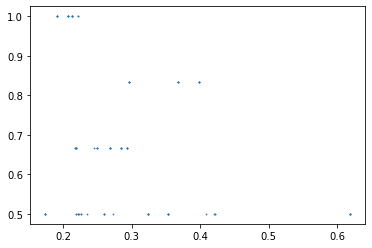

In [126]:
plt.scatter(cbs['V'],cbs['A'],s=0.5)

In [127]:
cbs.corr()

,I,V,A
I,1.000000,-0.098084,0.150673
V,-0.098084,1.000000,-0.298773
A,0.150673,-0.298773,1.000000


In [76]:
from datetime import date, timedelta

start_date = date(2021, 7, 28)
end_date = date(2021, 8, 1)

cbs1 = get_CBS1(df_filled, start_date, end_date, 60)
#cbs2 = get_CBS2(df_filled, start_date, end_date, 60)

3it [00:00, 19.60it/s]

        brand big_category                  prod_nm  overall(0.5)
0   sulhwasoo         catA               상백선크림 썸머키트            39
1   sulhwasoo         catA                   설린아이크림             1
2   sulhwasoo         catA                    설린에센스             1
3   sulhwasoo         catA   윤조&자음생 안티에이징 스페셜 리추얼세트             5
4   sulhwasoo         catA         윤조에센스 뷰티 시크릿 에디션            15
5   sulhwasoo         catA                      진설수             5
6   sulhwasoo         catA                    진설에센스             5
7   sulhwasoo         catA                     진설유액             2
8   sulhwasoo         catA                     진설크림             5
9   sulhwasoo         catA               탄력에센셜종 지함보            12
10  sulhwasoo         catB   자정 브라이트닝 쿠션 SPF+/PA+++             1
11  sulhwasoo         catB      진설 세럼 쿠션 SPF+/PA+++             2
12  sulhwasoo         catB     진설 세럼 파운데이션 SPF/PA++             4
13  sulhwasoo         catB      퍼펙팅 베일 베이스 SPF/PA++             1
14  sulhwa

4it [00:00, 19.60it/s]

        brand big_category                  prod_nm  overall(0.5)
0   sulhwasoo         catA               상백선크림 썸머키트            43
1   sulhwasoo         catA                   설린아이크림             1
2   sulhwasoo         catA                    설린에센스             1
3   sulhwasoo         catA   윤조&자음생 안티에이징 스페셜 리추얼세트             5
4   sulhwasoo         catA         윤조에센스 뷰티 시크릿 에디션            13
5   sulhwasoo         catA                      진설수             5
6   sulhwasoo         catA                    진설에센스             5
7   sulhwasoo         catA                     진설유액             2
8   sulhwasoo         catA                     진설크림             6
9   sulhwasoo         catA               탄력에센셜종 지함보            12
10  sulhwasoo         catB   자정 브라이트닝 쿠션 SPF+/PA+++             1
11  sulhwasoo         catB      진설 세럼 쿠션 SPF+/PA+++             2
12  sulhwasoo         catB     진설 세럼 파운데이션 SPF/PA++             4
13  sulhwasoo         catB      퍼펙팅 베일 베이스 SPF/PA++             1
14  sulhwa

In [77]:
cbs1

,brand,big_category,prod_nm,review_counts,date,score1,score2
0,sulhwasoo,catA,상백선크림 썸머키트,39,2021-07-28,0.529000,0.174444
1,sulhwasoo,catA,설린아이크림,1,2021-07-28,0.433500,0.219672
2,sulhwasoo,catA,설린에센스,1,2021-07-28,0.614500,0.368333
3,sulhwasoo,catA,윤조&자음생 안티에이징 스페셜 리추얼세트,5,2021-07-28,0.522500,0.295887
4,sulhwasoo,catA,윤조에센스 뷰티 시크릿 에디션,15,2021-07-28,0.518800,0.268501
5,sulhwasoo,catA,진설수,5,2021-07-28,0.541900,0.235715
6,sulhwasoo,catA,진설에센스,5,2021-07-28,0.488500,0.206833
7,sulhwasoo,catA,진설유액,2,2021-07-28,0.523500,0.284445
8,sulhwasoo,catA,진설크림,5,2021-07-28,0.492750,0.618350
9,sulhwasoo,catA,탄력에센셜종 지함보,12,2021-07-28,0.542200,0.218533


In [40]:
#cbs2
cbs2.groupby('prod_nm').mean().sum(axis=1)

prod_nm
동백윤모오일                      3.00
상백선크림 썸머키트                 40.75
설린아이크림                      1.00
설린에센스                       1.00
윤조&자음생 안티에이징 스페셜 리추얼세트      5.00
윤조에센스 뷰티 시크릿 에디션           13.75
자정 브라이트닝 쿠션 SPF+/PA+++      1.00
진설 세럼 쿠션 SPF+/PA+++         2.00
진설 세럼 파운데이션 SPF/PA++        4.00
진설수                         5.00
진설에센스                       5.00
진설유액                        2.00
진설크림                        5.25
탄력에센셜종 지함보                 12.00
퍼펙팅 베일 베이스 SPF/PA++         1.00
퍼펙팅 쿠션 SPF+/PA+++          14.00
퍼펙팅파운데이션 C + 산수화 브러쉬 세트     4.00
퍼펙팅파운데이션 N + 산수화 브러쉬 세트    14.25
퍼펙팅파운데이션 W + 산수화 브러쉬 세트     1.00
핸드크림 백은향                    3.50
dtype: float64

In [30]:
cbs1

,brand,big_category,prod_nm,review_counts,date,score1,score2
0,sulhwasoo,catA,상백선크림 썸머키트,39,2021-07-28,0.529000,0.174444
1,sulhwasoo,catA,설린아이크림,1,2021-07-28,0.433500,0.219672
2,sulhwasoo,catA,설린에센스,1,2021-07-28,0.614500,0.368333
3,sulhwasoo,catA,윤조&자음생 안티에이징 스페셜 리추얼세트,5,2021-07-28,0.522500,0.295887
4,sulhwasoo,catA,윤조에센스 뷰티 시크릿 에디션,15,2021-07-28,0.518800,0.268501
5,sulhwasoo,catA,진설수,5,2021-07-28,0.541900,0.235715
6,sulhwasoo,catA,진설에센스,5,2021-07-28,0.488500,0.206833
7,sulhwasoo,catA,진설유액,2,2021-07-28,0.523500,0.284445
8,sulhwasoo,catA,진설크림,5,2021-07-28,0.492750,0.618350
9,sulhwasoo,catA,탄력에센셜종 지함보,12,2021-07-28,0.542200,0.218533


In [21]:
temp=cbs1.groupby('prod_nm').mean()['variety_calc']

In [23]:
cbs2

,small_category,prod_nm,용량,민감성,향기,커버력,지속력,피부톤,보습감,향,사용감,발림성,세정력,촉촉함,유분기,발색감,제형
22,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.000000,0.000000,0.000000,0.138293,0.205306,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
23,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.000000,0.000000,0.000000,0.207289,0.000000,0.228398,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
24,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.000000,0.000000,0.000000,0.178721,0.215669,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.000000,0.000000,0.000000,0.200167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
26,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.000000,0.000000,0.000000,0.189500,0.211333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
27,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.000000,0.000000,0.000000,0.000000,0.000000,0.251667,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
35,cat2,진설수,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.243167,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
36,cat2,진설수,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.202000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
37,cat2,진설수,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.223000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
38,cat2,진설수,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [22]:
cbs1['variety_calc']

,A용량,A민감성,A향기,A커버력,A지속력,A피부톤,A보습감,A향,A사용감,A발림성,A세정력,A촉촉함,A유분기,A발색감,A제형,A보습력,category,rating,review_split,embed_sents,big_category,brand,date,prod_id,prod_nm,가격,감촉,광택,구성,디자인,만족도,발림,발색,보습,사용감,색상,성분,용기,용량,제형,지속,커버,트러블,표현력,품질,향기,효과,휴대성,mask,review_split_string,small_category,prod_nm_origin,overall(0),overall(0.5),overall(1),용량(0),민감성(0),향기(0),커버력(0),지속력(0),피부톤(0),보습감(0),향(0),사용감(0),발림성(0),세정력(0),촉촉함(0),유분기(0),발색감(0),제형(0),용량(0.5),민감성(0.5),향기(0.5),커버력(0.5),지속력(0.5),피부톤(0.5),보습감(0.5),향(0.5),사용감(0.5),발림성(0.5),세정력(0.5),촉촉함(0.5),유분기(0.5),발색감(0.5),제형(0.5),용량(1),민감성(1),향기(1),커버력(1),지속력(1),피부톤(1),보습감(1),향(1),사용감(1),발림성(1),세정력(1),촉촉함(1),유분기(1),발색감(1),제형(1),ATT_용량,ATT_민감성,ATT_향기,ATT_커버력,ATT_지속력,ATT_피부톤,ATT_보습감,ATT_향,ATT_사용감,ATT_발림성,ATT_세정력,ATT_촉촉함,ATT_유분기,ATT_발색감,ATT_제형,detect_counts,variety_emotion,max_aspect,variety_calc
22,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,cat4,5,"[제품이 좋아서 항상 사용하고 있습니다., 커버력도 좋고 지속력도 좋아요]","[[-0.0227792859, 0.12470483780000001, 0.565617...",catB,sulhwasoo,2021-07-14,21894,퍼펙팅 쿠션 SPF+/PA+++,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,1,1,0,0,0,"[True, True, False]","['제품이 좋아서 항상 사용하고 있습니다.', '커버력도 좋고 지속력도 좋아요']",cat4,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,0.308,0.319,0.374,0.000,0.000,0.000,0.313,0.091,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0.000,0.000,0.000,0.543,0.590,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0.000,0.000,0.000,0.144,0.320,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0.0,0.000000,0.0,0.499254,0.500746,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,2,0.515399,3,0.343599
23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,cat4,5,"[톤 21호 잘맞아요, 촉촉해서 커버는 아쉽지만 건성피부에 잘 맞는것 같아요, 리필...","[[-0.2921568155, 0.1134461612, -0.0501087904, ...",catB,sulhwasoo,2021-07-11,21894,퍼펙팅 쿠션 SPF+/PA+++,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,"[True, False, True]","['톤 21호 잘맞아요', '촉촉해서 커버는 아쉽지만 건성피부에 잘 맞는것 같아요'...",cat4,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,0.245,0.422,0.333,0.000,0.000,0.000,0.186,0.000,0.109,0.000,0.000,0.000,0.000,0,0,0,0,0,0.000,0.000,0.000,0.383,0.000,0.413,0.000,0.000,0.000,0.000,0,0,0,0,0,0.000,0.000,0.000,0.431,0.000,0.478,0.000,0.000,0.000,0.000,0,0,0,0,0,0.0,0.000000,0.0,0.499492,0.000000,0.500508,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,2,0.653531,3,0.435688
24,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,cat4,4,"[출시된 직후 10통 정도 사용할 만큼 만족도고좋은 제품이예요., 솔직히 파데 쓰는...","[[-0.2970165312, 0.29732012750000003, -0.42375...",catB,sulhwasoo,2021-07-01,21894,퍼펙팅 쿠션 SPF+/PA+++,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,1,1,0,0,0,"[True, True, False]","['출시된 직후 10통 정도 사용할 만큼 만족도고좋은 제품이예요.', '솔직히 파데...",cat4,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,0.383,0.337,0.280,0.000,0.000,0.000,0.180,0.109,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0.000,0.000,0.000,0.568,0.490,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0.000,0.000,0.000,0.253,0.401,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0.0,0.000000,0.0,0.499220,0.500780,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,2,0.591585,3,0.394390
25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,cat4,5,"[특유의 매화향이 나서 쿠션 두들길때마다 기분좋게 해주는 쿠션입니다., 다소 무거운...","[[0.1871506423, 0.321854949, 0.160717129700000...",catB,sulhwasoo,2021-06-20,21894,퍼펙팅 쿠션 SPF+/PA+++,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,1,1,1,0,"[True, False, False]","['특유의 매화향이 나서 쿠션 두들길때마다 기분좋게 해주는 쿠션입니다.', '다소 ...",cat4,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,0.353,0.363,0.284,0.000,0.000,0.000,0.142,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0.000,0.000,0.000,0.517,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0.000,0.000,0.000,0.342,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,1,0.600500,3,0.200167
26,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,cat4,5,[탄력이 없는 피부라 화장이 들뜬 느낌이 드는데 이제품은 커버력이 뛰어나 만족합니다],"[[1.0012266636, -0.0076161353, -0.3971077502, ...",catB,sulhwasoo,2021-06-18,21894,퍼펙팅 쿠션 SPF+/PA+++,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,1,0,1,1,0,1,0,"[True, True, False]",['탄력이 없는 피부라 화장이 들뜬 느낌이 드는데 이제품은 커버력이 뛰어나 만족합니다'],cat4,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,0.274,0.365,0.361,0.000,0.000,0.000,0.224,0.133,0.000,0.000,0.000,0.000,0.000,0,0,0,0,

In [17]:
cbs2

,small_category,prod_nm,용량,민감성,향기,커버력,지속력,피부톤,보습감,향,사용감,발림성,세정력,촉촉함,유분기,발색감,제형
22,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.000000,0.000000,0.000000,0.138293,0.205306,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
23,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.000000,0.000000,0.000000,0.207289,0.000000,0.228398,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
24,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.000000,0.000000,0.000000,0.178721,0.215669,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.000000,0.000000,0.000000,0.200167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
26,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.000000,0.000000,0.000000,0.189500,0.211333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
27,cat4,퍼펙팅 쿠션 SPF+/PA+++,0.000000,0.000000,0.000000,0.000000,0.000000,0.251667,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
35,cat2,진설수,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.243167,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
36,cat2,진설수,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.202000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
37,cat2,진설수,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.223000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
38,cat2,진설수,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
cbs1

In [81]:
cbs2

,brand,big_category,prod_nm,review_counts,date,score1,score2
0,sulhwasoo,catA,상백선크림 썸머키트,28,2021-07-21,0.529000,0.523333
1,sulhwasoo,catA,설린수,1,2021-07-21,0.428000,5.928549
2,sulhwasoo,catA,설린아이크림,1,2021-07-21,0.596500,0.219000
3,sulhwasoo,catA,설린에센스,3,2021-07-21,0.614500,0.368333
4,sulhwasoo,catA,설린크림,1,2021-07-21,0.553333,0.737887
5,sulhwasoo,catA,여윤팩,2,2021-07-21,0.524500,0.324869
6,sulhwasoo,catA,윤조&자음생 안티에이징 스페셜 리추얼세트,5,2021-07-21,0.529750,0.439667
7,sulhwasoo,catA,윤조마스크,1,2021-07-21,0.518800,1.342505
8,sulhwasoo,catA,윤조에센스,2,2021-07-21,0.528000,0.235333
9,sulhwasoo,catA,윤조에센스 뷰티 시크릿 에디션,17,2021-07-21,0.520000,0.462167


# Functions

In [ ]:
def S1_number_func(x):
    return(sum([len(x[i].split(' ')) for i in range(len(x))]))

def S1_duplicate_func(x):
    return(len(set(x))/len(x))
    
def NVA(x):    
    total_words=[]
    for i, document in enumerate(list(set(x))):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True): 
            if word[1] in ['Noun', 'Verb', 'Adjective']: 
                clean_words.append(word[0])
        total_words.append(clean_words)
    result = []
    for x in total_words:
        result.extend(x)
    return result


def S1_diversity_func(NVA):  
    return(len(set(NVA))/len(NVA))
    


def s1_recency_func(x,date):
    return((date-x.date()).days)

def S1_recency_func(x,max_date,window):
    """
    max=50 ( 50,49,,...1 )
    ----------------------------------------
    50,49,48,47,46 .... (max-0)~(max-window+1)
    49,48,47,46,45 .... (max-1)~(max-window+0)
    48,47,46,45,44 .... (max-2)~(max-window-1)
    ...
    5,4,3,2,1 ...,,,,,,. (max-45)~(max-window-44)
    ----------------------------------------
    max-45가 window가 될 때 까지
    """
    lower = max_date
    upper = max_date-window+1
    lower_sign=(x<=lower)
    upper_sign=(x>=upper)
    sign=lower_sign*upper_sign
    return sign

def s1_recency_list_func(prod_nm):
    tmp=S1_recency[S1_recency['prod_nm']==prod_nm]
    MA_list=[]
    for i in date_range:
        window_count = len(tmp['s1_recency'][tmp['s1_recency'].apply((lambda x: S1_recency_func(x,max_date-i,recency_window)))>0])
        window_count_mean = window_count/recency_window
        MA_list.append(window_count_mean)
    return MA_list

In [ ]:
temp_neg=(S23[S23.columns[(S23.columns.str.contains('(-1)'))&(~S23.columns.str.contains('overall'))]])*0
temp_neu=(S23[S23.columns[(S23.columns.str.contains('(0)'))&(~S23.columns.str.contains('overall'))]])*0.5
temp_pos=(S23[S23.columns[(S23.columns.str.contains('\(1\)'))&(~S23.columns.str.contains('overall'))]])*1
#temp_neg=(S23[S23.columns[(S23.columns.str.contains('(0)'))&(~S23.columns.str.contains('overall'))]])*(1e-6)
#temp_neu=(S23[S23.columns[(S23.columns.str.contains('(0.5)'))&(~S23.columns.str.contains('overall'))]])*0.5
#temp_pos=(S23[S23.columns[(S23.columns.str.contains('(1)'))&(~S23.columns.str.contains('overall'))]])*1
temp_ATT=S23[S23.columns[S23.columns.str.contains('ATT')]]
temp3=temp_ATT.isna().sum(axis=1)
weight_ATT=temp_ATT.shape[1]-temp3

deweight_ATT_dict={'catA':3,'catB':3,'catC':6,'catD':3,'catE':3}
deweight_ATT=S23['big_brand'].replace(deweight_ATT_dict)
temp_ATT.fillna(0,inplace=True)
W_df=temp_ATT.multiply(np.array((weight_ATT/deweight_ATT)),axis=0)

X_df=pd.DataFrame(temp_pos.fillna(0).values + temp_neu.fillna(0).values, columns=temp_pos.columns)

WX_df=pd.DataFrame(W_df.values*X_df.values,columns=W_df.columns,index=W_df.index)
WX_df.columns=[x[4:] for x in WX_df.columns]
WX_name_df=pd.concat([S23[['small_cat','name']],WX_df],axis=1)

# CBS

각 요소는 0~1사이 값을 가지도록 구성한다

## 날짜 범위 설정

- 점수 계산 날짜 : (x)일
- 점수 계산 대상 날짜 : (x-14)일~ (x)일

## Impression & Variety 계산 준비

In [ ]:
import torch

In [ ]:
model = torch.load('checkpoint39.pt',map_location='cpu')

In [15]:
cat_task = {'cat1': 1, 'cat2': 2,'cat3': 3,'cat4': 4,'cat5': 5,'cat6': 6,'cat7': 7,'cat9': 8,'cat10': 9}
cols1 = ['용량','민감성','향기','커버력','지속력','피부톤',
         '보습감','향','사용감','발림성','세정력', # 10
         '촉촉함','유분기','발색감','제형']#,'보습력']
cols2= df.columns[25:48]
small_cat_indices = [[1, 10, 11],
                     [1, 6, 7],
                     [1, 8, 9],

                     [3, 4, 5],

                     [4, 5, 11, 12, 13, 14],

                     [4, 8, 13],
                     [4, 8, 13],

                     [2, 1, 0],
                     [2, 1, 0]]

In [ ]:
def get_current_Kdays(df,current_Y,current_M,current_D,K=14):
    eval_date = datetime.date(current_Y,current_M,current_D)
    df['recency']=df['date'].apply((lambda x: s1_recency_func(x,eval_date)))
    return df[df['recency']<K]

df = get_current_Kdays(df_whole,2021,7,31,K=14)
recent_idx=df.index

In [16]:
temp_cols=["overall({})".format(i) for i in [-1,0,1]]+[c + '(-1)' for c in cols1]+[c + '(0)' for c in cols1]+[c + '(1)' for c in cols1]+['ATT_'+c for c in cols1]
S23=pd.DataFrame(index=recent_idx,columns=temp_cols)

NameError: name 'recent_idx' is not defined

In [ ]:
from tqdm import tqdm

In [ ]:
def softmax(x):
    return (torch.exp(x) / torch.exp(x).sum()).flatten()



def fill_s23(model, df, idicies):
    for ind in tqdm(idicies):
        
        review = torch.FloatTensor( df['embed_sents'][ind])
        num_sents = torch.tensor( len(review) )
        small_task= cat_task[ df['category'][ind] ]
        detect = df['mask'][ind]
        deteted_aspect= df.loc[ind,cols2][ df.loc[ind,cols2] == 1 ].index.values.tolist()
        deteted_aspect_ind = np.array( small_cat_indices[ small_task - 1 ] )[detect].tolist()
        deteted_aspect_target = np.array(cols1)[deteted_aspect_ind].tolist()
        model.eval()
        model.to('cpu')
        with torch.no_grad():
            out = model(review.unsqueeze(0), num_sents.unsqueeze(0))
        tg, ts, a1, a2, a3, a4, a5, a_g = out


        att_a = [a1[:3], a1[3:6],a1[6:], a2, a3, a4[:3], a4[4:], a5[:3], a5[3:]]

        overall_pred = dict( zip( ['5', '4', '1~3'], list(softmax(tg[small_task-1] )[[2,1,0]].data.numpy().round(3)) ) )

        S23.loc[ind,['overall(1)','overall(0)','overall(-1)']]=list(overall_pred.values())

        calibrated_imp = a_g[small_task-1].flatten()[[df['mask'][ind]]].numpy() / sum(a_g[small_task-1].flatten()[[df['mask'][ind]]].numpy() )
        aspect_imps = dict( zip( deteted_aspect_target, calibrated_imp) )

        for id_, (aspect_ind, aspect_name,aspect_imp) in enumerate(zip(deteted_aspect_ind, deteted_aspect_target,aspect_imps.values())):
        
            a_index = np.where( (np.array(small_cat_indices[small_task-1]) == aspect_ind))[0][0]
            aspect_pred = dict(zip(['1','0', '-1'], list(softmax(ts[small_task-1][a_index] )[[2,1,0]].data.numpy().round(3)) ))
            S23.loc[ind,aspect_name + '(1)']=aspect_pred['1']
            S23.loc[ind,aspect_name + '(0)']=aspect_pred['0']
            S23.loc[ind,aspect_name + '(-1)']=aspect_pred['-1']
            S23.loc[ind,'ATT_'+aspect_name]=aspect_imp



In [503]:
fill_s23(model,df,recent_idx)

100%|██████████████████████████████████████████████████████████████████████████████| 2059/2059 [01:33<00:00, 21.95it/s]


In [516]:
S23['small_cat']=df['small_cat']

In [517]:
S23['name']=df['name']

In [518]:
S23['big_brand']=S23['name'].apply(lambda x:(x.split('#')[1]))

In [523]:
temp_neg=(S23[S23.columns[(S23.columns.str.contains('(-1)'))&(~S23.columns.str.contains('overall'))]])*0
temp_neu=(S23[S23.columns[(S23.columns.str.contains('(0)'))&(~S23.columns.str.contains('overall'))]])*0.5
temp_pos=(S23[S23.columns[(S23.columns.str.contains('\(1\)'))&(~S23.columns.str.contains('overall'))]])*1
#temp_neg=(S23[S23.columns[(S23.columns.str.contains('(0)'))&(~S23.columns.str.contains('overall'))]])*(1e-6)
#temp_neu=(S23[S23.columns[(S23.columns.str.contains('(0.5)'))&(~S23.columns.str.contains('overall'))]])*0.5
#temp_pos=(S23[S23.columns[(S23.columns.str.contains('(1)'))&(~S23.columns.str.contains('overall'))]])*1
temp_ATT=S23[S23.columns[S23.columns.str.contains('ATT')]]
temp3=temp_ATT.isna().sum(axis=1)
weight_ATT=temp_ATT.shape[1]-temp3

deweight_ATT_dict={'catA':3,'catB':3,'catC':6,'catD':3,'catE':3}
deweight_ATT=S23['big_brand'].replace(deweight_ATT_dict)
temp_ATT.fillna(0,inplace=True)
W_df=temp_ATT.multiply(np.array((weight_ATT/deweight_ATT)),axis=0)

X_df=pd.DataFrame(temp_pos.fillna(0).values + temp_neu.fillna(0).values, columns=temp_pos.columns)

WX_df=pd.DataFrame(W_df.values*X_df.values,columns=W_df.columns,index=W_df.index)
WX_df.columns=[x[4:] for x in WX_df.columns]
WX_name_df=pd.concat([S23[['small_cat','name']],WX_df],axis=1)

C:\Users\LSH\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\LSH\Anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [524]:
def detected_aspect(WX_df):    
    cols = WX_df.columns
    bt = WX_df.apply(lambda x: x > 0)
    bt = bt.apply(lambda x: list(cols[x.values]), axis=1)
    return bt

In [675]:
tt=df['name'].value_counts()

# 끝끝끝끝끝끝끝끝끝끝끝끝끝끝끝끝ㅍ

In [679]:
SCORE_I=WX_name_df.groupby('name').sum().sum(axis=1)

# 끝끝끝끝끝끝끝끝끝끝끝끝끝

In [680]:
for ttt in t.index:
    print(SCORE_I[ttt])
    print(t[ttt])
    print('hahahah')

1.4253904123291865
1.4253904123291865
hahahah
1.0973272751466738
1.0973272751466738
hahahah
0.21550000210603076
0.21550000210603076
hahahah
2.328062400474592
2.328062400474592
hahahah
1.6808326209826387
1.6808326209826387
hahahah
0.4353333363930384
0.4353333363930384
hahahah
0.4466666628917058
0.4466666628917058
hahahah
0.46450000504652655
0.46450000504652655
hahahah
1.4566666732231777
1.4566666732231777
hahahah
2.40902518897269
2.40902518897269
hahahah
0.6881666630506516
0.6881666630506516
hahahah
0.2070000022649765
0.2070000022649765
hahahah
0.22516667346159616
0.22516667346159616
hahahah
0.22433333098888397
0.22433333098888397
hahahah
0.17933333665132523
0.17933333665132523
hahahah
0.45706817028767444
0.45706817028767444
hahahah
0.22233333190282184
0.22233333190282184
hahahah
0.8436783840578861
0.8436783840578861
hahahah
2.9717374402627073
2.9717374402627073
hahahah
2.8235860290868873
2.8235860290868873
hahahah
0.6591596748095911
0.6591596748095911
hahahah
0.20516667266686756
0.2051

In [676]:
t.index

Index(['amore#catA# 모이스춰 플럼핑 듀이 미스트', 'amore#catA#더 에센셜 크림 플루이드',
       'amore#catA#라인에이징 코렉터', 'amore#catA#모이스춰 플럼핑 넥타 크림',
       'amore#catA#모이스춰 플럼핑 듀이 미스트', 'amore#catA#모이스춰플럼핑 리쥬브네이팅 아이 젤',
       'amore#catA#보태니컬 수딩 토너', 'amore#catA#보태니컬 하이드레이팅 플루이드',
       'amore#catA#빈티지 싱글 익스트렉트 앰플', 'amore#catA#빈티지 싱글 익스트렉트 에센스',
       ...
       'sulhwasoo#catB# 퍼펙팅 쿠션 SPF+/PA+++',
       'sulhwasoo#catB# 퍼펙팅 트윈케이크 SPF/PA+++',
       'sulhwasoo#catB# 퍼펙팅파운데이션 C + 산수화 브러쉬 세트',
       'sulhwasoo#catB# 퍼펙팅파운데이션 N + 산수화 브러쉬 세트',
       'sulhwasoo#catB#퍼펙팅 베일 베이스 SPF/PA++',
       'sulhwasoo#catB#퍼펙팅 쿠션 SPF+/PA+++', 'sulhwasoo#catB#퍼펙팅 파우더',
       'sulhwasoo#catE#동백윤모오일', 'sulhwasoo#catE#트래블키트 백은향',
       'sulhwasoo#catE#핸드크림 백은향'],
      dtype='object', name='name', length=300)

In [545]:
WX_name_df['small_cat'].apply(lambda x:int(x[3]))

22       4
23       4
60       2
76       2
77       2
        ..
48344    2
48345    2
48346    2
48347    2
48348    2
Name: small_cat, Length: 2059, dtype: int64

In [552]:
WX_name_df.groupby('name').get_group(temp_name[22])['small_cat'].values[0]

'cat4'

In [101]:
def sentiment_cooc(emotion,prod_name):
    aspects=['용량','민감성','향기','커버력',
             '지속력','피부톤','보습감','향','사용감',
             '발림성','세정력','촉촉함','유분기','발색감','제형']
    
    cat_detected = [['민감성','세정력','촉촉함'],
                     ['민감성', '보습감','향'],
                     ['민감성', '사용감', '발림성'],

                     ['커버력', '지속력', '피부톤'],

                     ['지속력','피부톤', '촉촉함', '유분기','발색감','제형'],

                     ['지속력', '사용감', '발색감'],
                     ['지속력', '사용감', '발색감'],

                     ['향기', '민감성', '용량'],
                     ['향기', '민감성', '용량']]
    
    # (1) detect aspect
    prod_name_group=emotion.groupby('prod_nm').get_group(prod_name)
    small_cat_idx=int(prod_name_group['small_category'].values[0][3])
    prod_name_sum=prod_name_group.sum()[aspects]
    small_cat_detected=cat_detected[small_cat_idx-1]
    detected_aspect_sent=prod_name_sum[small_cat_detected]
    
    # make co-occurence matrix with 
    sent_cooc=np.ones((len(small_cat_detected)+1,len(small_cat_detected)+1))*np.mean(detected_aspect_sent)
    sent_cooc[0,1:]=np.array(detected_aspect_sent)
    sent_cooc[1:,0]=np.array(detected_aspect_sent)
    np.fill_diagonal(sent_cooc,0)
    
    # as dataframe
    sent_cooc=pd.DataFrame(sent_cooc,
                           columns=[prod_name]+small_cat_detected,
                           index=[prod_name]+small_cat_detected)
    return sent_cooc


def connectivity_from_cooc(cooc_mat):
    conn = cooc_mat.stack()
    conn=conn.rename_axis(('source','target')).reset_index(name='weight')
    G = nx.from_pandas_edgelist(conn,edge_attr=True)

    for u,v,data in G.edges(data=True):
        if 'weight' in data and data['weight']!=0:
            data['inverse']=1/data['weight']
        else:
            data['inverse']=1
    
    connectivity = nx.betweenness_centrality(G,normalized=True,weight='inverse',endpoints =True)
    time3 = time.time()

    return connectivity

In [ ]:
prod_nm='퍼펙팅 쿠션 SPF+/PA+++'
cooc=sentiment_cooc(emotion,prod_nm)
prod_score3 = connectivity_from_cooc(cooc)

In [109]:
emotion[emotion.prod_nm=='퍼펙팅 쿠션 SPF+/PA+++']

(14, 17)

In [102]:
t=sentiment_cooc(emotion,'퍼펙팅 쿠션 SPF+/PA+++')

커버력    2.09516
지속력    1.24415
피부톤    1.18944
dtype: object


In [104]:
def connectivity_from_cooc(cooc_mat):
    conn = cooc_mat.stack()
    conn=conn.rename_axis(('source','target')).reset_index(name='weight')
    G = nx.from_pandas_edgelist(conn,edge_attr=True)

    for u,v,data in G.edges(data=True):
        if 'weight' in data and data['weight']!=0:
            data['inverse']=1/data['weight']
        else:
            data['inverse']=1
    
    connectivity = nx.betweenness_centrality(G,normalized=True,weight='inverse',endpoints =True)
    time3 = time.time()

    return connectivity

In [105]:
connectivity_from_cooc(t)

{'퍼펙팅 쿠션 SPF+/PA+++': 0.5, '커버력': 0.5, '지속력': 0.5, '피부톤': 0.5}

In [106]:
t

,퍼펙팅 쿠션 SPF+/PA+++,커버력,지속력,피부톤
퍼펙팅 쿠션 SPF+/PA+++,0.000000,2.095158,1.244147,1.189437
커버력,2.095158,0.000000,1.509581,1.509581
지속력,1.244147,1.509581,0.000000,1.509581
피부톤,1.189437,1.509581,1.509581,0.000000


In [609]:
t=a[b]
k=np.ones((len(small_cat_detected),len(small_cat_detected)))*np.mean(t)
np.fill_diagonal(k,0)

In [637]:
k=np.ones((4,4))*np.mean(t)
np.fill_diagonal(k,0)

In [640]:
np.fill_diagonal(k,0)

In [641]:
k

array([[0.        , 0.93345784, 0.4139696 , 0.22839829],
       [0.93345784, 0.        , 0.52527524, 0.52527524],
       [0.4139696 , 0.52527524, 0.        , 0.52527524],
       [0.22839829, 0.52527524, 0.52527524, 0.        ]])

In [639]:
#k[0,1:]=np.array(t)
#k[1:,0]=np.array(t)
k.diagonal()=0

SyntaxError: cannot assign to function call (Temp/ipykernel_18848/3692993522.py, line 3)

In [636]:
k.diagonal=0

ValueError: Input must be 1- or 2-d.

In [622]:
np.mean(t)

0.5252752440705483

In [599]:
tt=pd.DataFrame(t,columns=[str(temp_name[22])])

In [608]:
t

'sulhwasoo#catB# 퍼펙팅 쿠션 SPF+/PA+++'

In [606]:
for t in tt:
    tt.loc[:,t]=np.nan

In [607]:
tt

,sulhwasoo#catB# 퍼펙팅 쿠션 SPF+/PA+++
커버력,NaN
지속력,NaN
피부톤,NaN


In [593]:
#tt.loc[str(temp_name[22]),]=0

In [596]:
t

커버력    0.933458
지속력     0.41397
피부톤    0.228398
dtype: object

In [597]:
for t in tt.index:
    print(t)

커버력
지속력
피부톤
sulhwasoo#catB# 퍼펙팅 쿠션 SPF+/PA+++


In [350]:
temp_name=WX_name_df['name']

In [352]:
temp_name[22]

'sulhwasoo#catB# 퍼펙팅 쿠션 SPF+/PA+++'

In [349]:
WX_name_df.groupby('name').get_group('sum()

,용량,민감성,향기,커버력,지속력,피부톤,보습감,향,사용감,발림성,세정력,촉촉함,유분기,발색감,제형
name,,,,,,,,,,,,,,,
amore#catA# 모이스춰 플럼핑 듀이 미스트,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.913043,0.512347,0.0,0.0,0.0,0.0,0.0,0.0,0.0
amore#catA#더 에센셜 크림 플루이드,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.876273,0.221054,0.0,0.0,0.0,0.0,0.0,0.0,0.0
amore#catA#라인에이징 코렉터,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.215500,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
amore#catA#모이스춰 플럼핑 넥타 크림,0.000000,0.200974,0.000000,0.000000,0.000000,0.000000,1.937833,0.189256,0.0,0.0,0.0,0.0,0.0,0.0,0.0
amore#catA#모이스춰 플럼핑 듀이 미스트,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.335515,0.345318,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sulhwasoo#catB#퍼펙팅 쿠션 SPF+/PA+++,0.000000,0.000000,0.000000,2.814476,2.158736,3.672872,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sulhwasoo#catB#퍼펙팅 파우더,0.000000,0.000000,0.000000,0.146457,0.207630,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sulhwasoo#catE#동백윤모오일,0.000000,0.000000,0.154167,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [347]:
WX_name_df.groupby('name').get_group('hera#catC#루즈홀릭').sum()

name    hera#catC#루즈홀릭hera#catC#루즈홀릭hera#catC#루즈홀릭hera...
용량                                                      0
민감성                                                     0
향기                                                      0
커버력                                                     0
지속력                                              0.279128
피부톤                                               1.35787
보습감                                                     0
향                                                       0
사용감                                                     0
발림성                                                     0
세정력                                                     0
촉촉함                                              0.466675
유분기                                                1.1457
발색감                                              0.715899
제형                                               0.101319
dtype: object

In [346]:
(WX_name_df.groupby('name').sum()==0).sum(axis=1)[(WX_name_df.groupby('name').sum()==0).sum(axis=1)==9]

name
hera#catC#루즈홀릭                 9
hera#catC#센슈얼 스파이시 누드 글로스      9
hera#catC#센슈얼 스파이시 누드 볼륨 매트    9
hera#catC#센슈얼 파우더 매트           9
hera#catC#아이 엠 센슈얼 파우더 매트      9
dtype: int64

In [327]:
detected_aspect(WX_df)

22       [커버력, 지속력]
23       [커버력, 피부톤]
60            [보습감]
76         [보습감, 향]
77         [보습감, 향]
            ...    
48344         [보습감]
48345      [보습감, 향]
48346         [보습감]
48347         [보습감]
48348         [보습감]
Length: 2059, dtype: object

In [321]:

cols = WX_df.columns
bt = WX_df.apply(lambda x: x > 0)
bt.apply(lambda x: list(cols[x.values]), axis=1)

22       [커버력, 지속력]
23       [커버력, 피부톤]
60            [보습감]
76         [보습감, 향]
77         [보습감, 향]
            ...    
48344         [보습감]
48345      [보습감, 향]
48346         [보습감]
48347         [보습감]
48348         [보습감]
Length: 2059, dtype: object

(array([ 124.,  303., 1028.,   49.,  115.,  357.,   44.,    7.,   16.,
          16.]),
 array([0.06716667, 0.13021482, 0.19326298, 0.25631113, 0.31935928,
        0.38240744, 0.44545559, 0.50850374, 0.5715519 , 0.63460005,
        0.6976482 ]),
 <BarContainer object of 10 artists>)

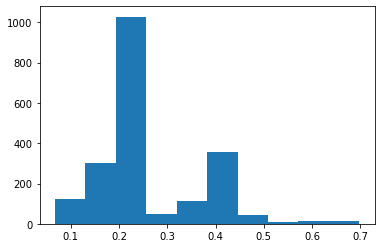

In [305]:
plt.hist(WX_df.sum(axis=1))

In [300]:
X_df.head()

,용량(1),민감성(1),향기(1),커버력(1),지속력(1),피부톤(1),보습감(1),향(1),사용감(1),발림성(1),세정력(1),촉촉함(1),유분기(1),발색감(1),제형(1)
0,0.0,0.0,0.0,0.4155,0.615,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.6225,0.000,0.6845,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0000,0.000,0.0000,0.606,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0000,0.000,0.0000,0.675,0.7245,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0000,0.000,0.0000,0.675,0.7245,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
# (NA) 56,52,48,44 -> (not NA) 8,12,16,20
# 8-4=4 :  d1 (3+1)x1
# 12-4=8 : d2 (3+1)x2
# 16-4=12 : d3 (3+1)x3
# 20-4=16 : d4 (3+1)x4
S23.isna().sum(axis=1).value_counts()

56    1405
52     567
48      71
44      16
dtype: int64

In [21]:
fill_s23(model, df,recent_idx)

100%|██████████████████████████████████████████████████████████████████████████████| 2059/2059 [01:33<00:00, 22.06it/s]


In [22]:
S23_copy = S23.copy()

In [23]:
eps=1
product_info=df[['name','big_category','brand','rating']]
product_sent_ratio=pd.crosstab(product_info.name, product_info.rating)
product_sent_ratio+=eps
product_sent_inv_ratio=product_sent_ratio.apply(lambda x : 1/x)
product_sent_inv_ratio=product_sent_inv_ratio.div(product_sent_inv_ratio.sum(axis=1), axis=0)
product_sent_inv_ratio.columns=['W_overall(-1)','W_overall(0)','W_overall(1)']
product_sent_inv_ratio.reset_index(inplace=True)

In [24]:
S23=pd.concat([S23,df['name']],axis=1)

##  (score 1) Impression

In [25]:
S2=S23[['overall(-1)','overall(0)','overall(1)','name']]

In [26]:
S2=pd.merge(S2,product_sent_inv_ratio,on='name',how='left')

In [27]:
S2['score(-1)']=(S2['overall(-1)']*S2['W_overall(-1)']).astype('float')
S2['score(0)']=(S2['overall(0)']*S2['W_overall(0)']).astype('float')
S2['score(1)']=(S2['overall(1)']*S2['W_overall(1)']).astype('float')

In [28]:
S2=S2[['name','score(-1)','score(0)','score(1)']]

In [29]:
S2=S2.groupby('name').mean()[['score(-1)','score(1)']]

In [30]:
S2=pd.DataFrame(S2['score(1)']-S2['score(-1)'],columns=['S2'])

In [31]:
score1 = S2

<AxesSubplot:>

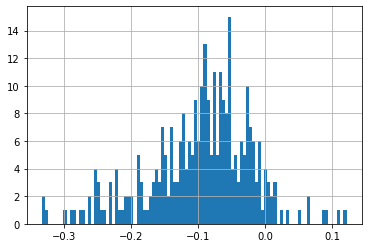

In [32]:
score1['S2'].hist(bins=100)

## (score 2) Variety

In [33]:
new_S3=S23[['name']]

W_temp=pd.merge(new_S3,product_sent_inv_ratio,on='name',how='left')

In [34]:
for col in cols1:
    X_temp=S23[S23.columns[S23.columns.str.contains(col)]]
    X_temp.iloc[:,:3]=X_temp.iloc[:,:3].mul(X_temp.iloc[:,3],axis=0)
    score_plus=np.array(X_temp[col+'(1)'])*np.array(W_temp['W_overall(1)'])
    score_minus=np.array(X_temp[col+'(-1)'])*np.array(W_temp['W_overall(-1)'])
    score_sum=score_plus-score_minus
    new_S3[col]=score_sum

C:\Users\LSH\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\LSH\AppData\Local\Temp/ipykernel_18848/2004163277.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_temp.iloc[:,:3]=X_temp.iloc[:,:3].mul(X_temp.iloc[:,3],axis=0)
C:\Users\LSH\AppData\Local\Temp/ipykernel_18848/2004163277.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [35]:
product_names=list(set(S23['name']))

In [36]:
S3=pd.DataFrame(index=S2.index,columns=cols1)

In [37]:
for prod_nm in product_names:
    prod_df=new_S3.groupby('name').get_group(prod_nm)    
    score_x=prod_df.mean()
    w=prod_df.shape[0]-prod_df.iloc[:,1:].isna().sum()
    score_w=w/w.sum()
    score_w=score_w.fillna(0)
    score=(score_x*score_w)

    S3.loc[prod_nm,:]=score

In [38]:
score2=pd.DataFrame(S3.sum(axis=1),columns=['S3'])

In [41]:
score2 = S3

In [43]:
#score2['S3'].hist(bins=100)

## (score 3) Association

속성 단어 사전

In [44]:
def get_coocmat(nva_topK):
    u = (pd.get_dummies(pd.DataFrame(nva_topK), prefix='', prefix_sep='')
       .groupby(level=0, axis=1)
       .sum())

    cooc_mat = u.T.dot(u)
    cooc_mat.values[(np.r_[:len(cooc_mat)], ) * 2] = 0
    return cooc_mat
    

In [45]:
def connectivity_from_cooc(coocurence_mat):
    cooc_mat = coocurence_mat.copy()
    #print('shape of coocurrence matrix :',cooc_mat.shape)
    time1 = time.time()
    conn = cooc_mat.stack()
    conn=conn.rename_axis(('source','target')).reset_index(name='weight')
    G = nx.from_pandas_edgelist(conn,edge_attr=True)
    time2 = time.time()
    #print('Constructing Graph took {} secs'.format(time2-time1))
    for u,v,data in G.edges(data=True):
        if 'weight' in data and data['weight']!=0:
            data['inverse']=1/data['weight']
        else:
            data['inverse']=1
    connectivity = nx.betweenness_centrality(G,normalized=True,weight='inverse',endpoints =True)
    time3 = time.time()
    #print('Calculating Connectivity took {} secs'.format(time3-time2))
    return connectivity

In [46]:
aspect_list = ['가격','광택','구성','디자인','만족도','맛','성분','용기','트렌드','표현','품질','휴대']

In [47]:
nva=df['review_split'].apply(NVA)

In [48]:
#max_window = max([len(i) for i in nva]) -1
#nva_for_w2v=df_whole['review_split'].apply(NVA)
#model = Word2Vec(sentences=nva_for_w2v, size=100, window=max_window, min_count=5, workers=4, sg=0)
#model.wv.save_word2vec_format('aspect_dict_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("aspect_dict_w2v") # 모델 로드

In [49]:
aspect_dict = {}
for aspect in aspect_list:
    tmp=loaded_model.most_similar(aspect,topn=30)    
    aspect_dict[aspect]=[i[0] for i in tmp]

In [50]:
import itertools
import collections

In [51]:
def leave_only_aspect_and_product(nva,aspect_dict,node='brand'):
    #------------------------------------------------------------
    # [STEP 1] network의 node로 삼을 범위 
    # --- 후보 1) brand         ( ex. sulhwasoo )
    # --- 후보 2) brand+big     ( ex. sulhwasoo#catA )
    # --- 후보 3) brand+big+prd ( ex. sulhwasoo#catA#윤조&자음생 안티에이징 스페셜 리추얼세트(쇼핑백 포함) )
    #------------------------------------------------------------
    nva_replaced=[]
    nva_idx=nva.index
    
    assert node in ['brand','brand+big','brand+big+prd']
    if node=='brand':
        names=list(df['brand'])
    elif node=='brand+big':
        names=list(df['name_sub'])
    else:
        names=list(df['name'])
    
    #------------------------------------------------------------
    # [STEP 2] 중복되는 단어를 가진 속성 단어는, 양쪽에서 모두 제거하기
    # --- 근거 1) 어느쪽에 포함시켜야할지 manually 정해야
    # --- 근거 2) (2 이상의)여러 쪽에 속해 있다 = general한 속성이다
    #------------------------------------------------------------
    aspect_words_total=list(itertools.chain(*list(aspect_dict.values())))
    duplicate_words=[item for item, count in collections.Counter(aspect_words_total).items() if count > 1]
    for aspect in aspect_list:
        aspect_dict[aspect]=[word for word in aspect_dict[aspect] if word not in  duplicate_words]
    
    #------------------------------------------------------------
    # [STEP 3] aspect dictionary를 inverse 시키기
    #------------------------------------------------------------
    aspect_words_total_filtered=list(itertools.chain(*list(aspect_dict.values())))
    num_values_per_aspect=[len(list(aspect_dict.values())[i]) for i in range(len(aspect_dict.keys()))]
    keys_ = [num_values_per_aspect[i]*[list(aspect_dict.keys())[i]] for i in range(len(aspect_dict.keys()))]
    keys_=list(itertools.chain(*keys_))
    
    word2aspect_dict = dict(zip(aspect_words_total_filtered,keys_))
    
    #------------------------------------------------------------
    # [STEP 4] 리뷰 내에 "속성 단어"가 있을 경우, "속성"으로 대체하고, 없으면 제거
    #------------------------------------------------------------
    for i in range(len(nva)):
        nva_ = nva[nva_idx[i]]
        tmp=list(set([x.replace(x, word2aspect_dict[x]) for x in nva_ if x in aspect_words_total_filtered]))
        if len(tmp)>0:
            tmp.append(names[i])
            nva_replaced.append(tmp)
    return (nva_replaced)

In [ ]:
review_filtered_name=leave_only_aspect_and_product(nva,aspect_dict,'brand+big+prd')
cooc_mat_brand=get_coocmat(review_filtered_name)

association_dict_brand=dict()
temp1=[]
temp2=[]
for brand in brand_list:
    result_cooc,result_score=cooc_mat_NAME(brand,review_filtered_brand)
    temp1.append(result_score)
    temp2.append(result_cooc)
    association_dict_brand[brand]=result_score[brand]

In [52]:
review_filtered_brand=leave_only_aspect_and_product(nva,aspect_dict,'brand')
review_filtered_brand_big=leave_only_aspect_and_product(nva,aspect_dict,'brand+big')
review_filtered_name=leave_only_aspect_and_product(nva,aspect_dict,'brand+big+prd')

In [116]:
def cooc_mat_NAME(name,review_filtered):
    cooc=get_coocmat([i for i in review_filtered if name in i])
    for col in aspect_list:
        if col not in cooc.columns:
            cooc.loc[col,col]=0
    cooc.fillna(0,inplace=True)
    tmp=aspect_list+[name]
    result_cooc=cooc.loc[tmp,tmp]
    #------------------------------------------
    result_cooc[name]=result_cooc[name]*(np.sum(result_cooc.iloc[:-1,:-1]).max()/result_cooc[name].sum())
    result_cooc[name]=np.max(result_cooc.iloc[:-1,:-1],axis=1)
    result_cooc.loc[name,:-1]=result_cooc[name][:-1]
    result_cooc.iloc[-1,-1]=0
    #------------------------------------------    
    return result_cooc,connectivity_from_cooc(result_cooc)

### case 1) brand

In [325]:
len(review_filtered_brand)

910

In [117]:
cooc_mat_brand=get_coocmat(review_filtered_brand)

In [118]:
brand_list=cooc_mat_brand.columns[:8]

In [124]:
association_dict_brand=dict()
temp1=[]
temp2=[]
for brand in brand_list:
    result_cooc,result_score=cooc_mat_NAME(brand,review_filtered_brand)
    temp1.append(result_score)
    temp2.append(result_cooc)
    association_dict_brand[brand]=result_score[brand]

In [136]:
association_dict_brand

{'amore': 0.3696581196581196,
 'hanyul': 0.611111111111111,
 'hera': 0.4807692307692307,
 'iope': 0.23076923076923075,
 'laneige': 0.3846153846153846,
 'mamonde': 0.4401709401709401,
 'primera': 0.5363247863247863,
 'sulhwasoo': 0.3782051282051282}

In [135]:
np.sum(temp2[2],axis=1)

가격      19.0
광택      31.0
구성      28.0
디자인     51.0
만족도     26.0
맛       13.0
성분       5.0
용기      21.0
트렌드      2.0
표현      50.0
품질      24.0
휴대      51.0
hera    65.0
dtype: float64

In [129]:
temp2[2]

,가격,광택,구성,디자인,만족도,맛,성분,용기,트렌드,표현,품질,휴대,hera
가격,0.0,0.0,1.0,4.0,1.0,1.0,1.0,1.0,0.0,2.0,2.0,2.0,4.0
광택,0.0,0.0,3.0,4.0,2.0,1.0,0.0,2.0,1.0,5.0,1.0,6.0,6.0
구성,1.0,3.0,0.0,5.0,2.0,2.0,0.0,3.0,0.0,2.0,0.0,5.0,5.0
디자인,4.0,4.0,5.0,0.0,2.0,2.0,0.0,3.0,0.0,10.0,2.0,9.0,10.0
만족도,1.0,2.0,2.0,2.0,0.0,2.0,0.0,1.0,0.0,6.0,1.0,3.0,6.0
맛,1.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
성분,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
용기,1.0,2.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,4.0
트렌드,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
표현,2.0,5.0,2.0,10.0,6.0,1.0,2.0,2.0,0.0,0.0,5.0,5.0,10.0


In [130]:
temp1[2]

{'가격': 0.15384615384615385,
 '광택': 0.15384615384615385,
 '구성': 0.15384615384615385,
 '디자인': 0.1923076923076923,
 '만족도': 0.15384615384615385,
 '맛': 0.15384615384615385,
 '성분': 0.15384615384615385,
 '용기': 0.15384615384615385,
 '트렌드': 0.15384615384615385,
 '표현': 0.17307692307692307,
 '품질': 0.15384615384615385,
 '휴대': 0.1987179487179487,
 'hera': 0.4807692307692307}

In [126]:
temp2[0]

,가격,광택,구성,디자인,만족도,맛,성분,용기,트렌드,표현,품질,휴대,amore
가격,0.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0
광택,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
구성,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,3.0,0.0,3.0
디자인,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,2.0
만족도,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
맛,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
성분,1.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0
용기,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0
트렌드,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
표현,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [127]:
temp1[0]


{'가격': 0.15384615384615385,
 '광택': 0.15384615384615385,
 '구성': 0.15384615384615385,
 '디자인': 0.15384615384615385,
 '만족도': 0.15384615384615385,
 '맛': 0.15384615384615385,
 '성분': 0.15384615384615385,
 '용기': 0.15384615384615385,
 '트렌드': 0.15384615384615385,
 '표현': 0.15384615384615385,
 '품질': 0.1645299145299145,
 '휴대': 0.16025641025641024,
 'amore': 0.3696581196581196}

In [121]:
association_dict_brand

{'amore': 0.3696581196581196,
 'hanyul': 0.611111111111111,
 'hera': 0.4807692307692307,
 'iope': 0.23076923076923075,
 'laneige': 0.3846153846153846,
 'mamonde': 0.4401709401709401,
 'primera': 0.5363247863247863,
 'sulhwasoo': 0.3782051282051282}

In [120]:
result_cooc

,가격,광택,구성,디자인,만족도,맛,성분,용기,트렌드,표현,품질,휴대,sulhwasoo
가격,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
광택,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
구성,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0,4.0,1.0,5.0,5.0
디자인,0.0,0.0,1.0,0.0,3.0,0.0,0.0,5.0,0.0,7.0,0.0,2.0,7.0
만족도,1.0,0.0,3.0,3.0,0.0,1.0,0.0,1.0,0.0,7.0,1.0,1.0,7.0
맛,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
성분,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0
용기,1.0,0.0,1.0,5.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,5.0
트렌드,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
표현,0.0,0.0,4.0,7.0,7.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,7.0


In [103]:
result_cooc['sulhwasoo']=result_cooc['sulhwasoo']*(np.sum(result_cooc.iloc[:-1,:-1]).max()/result_cooc['sulhwasoo'].sum())
result_cooc['sulhwasoo']=np.max(result_cooc.iloc[:-1,:-1],axis=1)
result_cooc.loc['sulhwasoo',:-1]=result_cooc['sulhwasoo'][:-1]
result_cooc.iloc[-1,-1]=0

In [109]:
result_cooc['sulhwasoo']=np.max(result_cooc.iloc[:-1,:-1],axis=1)

In [114]:
result_cooc.loc['sulhwasoo',:-1]=result_cooc['sulhwasoo'][:-1]
result_cooc.iloc[-1,-1]=0

In [115]:
result_cooc

,가격,광택,구성,디자인,만족도,맛,성분,용기,트렌드,표현,품질,휴대,sulhwasoo
가격,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
광택,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
구성,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0,4.0,1.0,5.0,5.0
디자인,0.0,0.0,1.0,0.0,3.0,0.0,0.0,5.0,0.0,7.0,0.0,2.0,7.0
만족도,1.0,0.0,3.0,3.0,0.0,1.0,0.0,1.0,0.0,7.0,1.0,1.0,7.0
맛,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
성분,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0
용기,1.0,0.0,1.0,5.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,5.0
트렌드,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
표현,0.0,0.0,4.0,7.0,7.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,7.0


In [89]:
temp_sum=np.sum(np.sum(result_cooc.iloc[:-1,:-1],axis=1))
temp_mean=np.mean(np.sum(result_cooc.iloc[:-1,:-1],axis=1))

In [91]:
result_cooc['sulhwasoo']=result_cooc['sulhwasoo']/temp_mean

In [92]:
result_cooc

,가격,광택,구성,디자인,만족도,맛,성분,용기,트렌드,표현,품질,휴대,sulhwasoo
가격,0,0,0,0,1,0,0,1,0,0,1,1,0.857143
광택,0,0,0,0,0,0,0,0,0,0,0,0,0.107143
구성,0,0,0,1,3,0,0,1,1,4,1,5,2.464286
디자인,0,0,1,0,3,0,0,5,0,7,0,2,2.571429
만족도,1,0,3,3,0,1,0,1,0,7,1,1,1.714286
맛,0,0,0,0,1,0,0,0,0,2,0,0,0.428571
성분,0,0,0,0,0,0,0,2,0,0,1,0,0.535714
용기,1,0,1,5,1,0,2,0,0,1,0,0,0.964286
트렌드,0,0,1,0,0,0,0,0,0,0,0,0,0.107143
표현,0,0,4,7,7,2,0,1,0,0,0,1,4.607143


In [321]:
#connectivity_tmp_brand = connectivity_from_cooc(cooc_mat_brand)

In [117]:
#brand_included=list(set([i[-1] for i in review_filtered_brand]))

In [118]:
# tmp=[]
# for b in brand_included:
#     tmp.append(connectivity_tmp_brand[b])
# connectivity=tmp/max(np.array(tmp))

# score3_brand=dict(zip(brand_included,connectivity))

In [ ]:
review_filtered_name=leave_only_aspect_and_product(nva,aspect_dict,'brand+big+prd')
cooc_mat_brand=get_coocmat(review_filtered_name)

### case 2) brand + big

In [61]:
cooc_mat_brand_big=get_coocmat(review_filtered_brand_big)

In [62]:
brand_big_list=cooc_mat_brand_big.columns[cooc_mat_brand_big.columns.str.contains('#')]

In [64]:
association_dict_brand_big=dict()

for brand_big in brand_big_list:
    result_cooc,result_score=cooc_mat_NAME(brand_big,review_filtered_brand_big)
    association_dict_brand_big[brand_big]=result_score[brand_big]

In [329]:
abcd=df['name_sub'].value_counts().sort_index()

In [312]:
#list(abcd[association_dict.keys()].values)

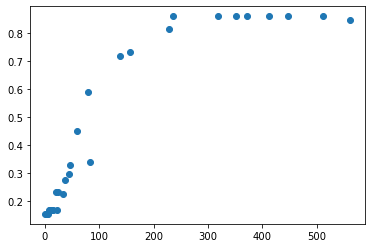

In [330]:
plt.scatter(list(abcd[association_dict.keys()].values),association_dict.values())

In [272]:
a,b=cooc_mat_NAME('iope#catA',review_filtered_brand_big)

In [267]:
c,d=cooc_mat_NAME('hera#catC',review_filtered_brand_big)

In [ ]:
df['sub'].value_counts()['amore#catA# 모이스춰 플럼핑 듀이 미스트']

In [287]:
df['name_sub'].value_counts()['iope#catA']

371

In [268]:
b

{'가격': 12.0,
 '광택': 12.0,
 '구성': 12.0,
 '디자인': 12.0,
 '만족도': 12.0,
 '맛': 12.0,
 '성분': 12.0,
 '용기': 12.0,
 '트렌드': 12.0,
 '표현': 12.0,
 '품질': 12.0,
 '휴대': 12.0,
 'iope#catA': 67.0}

In [269]:
a
#print(b)

,가격,광택,구성,디자인,만족도,맛,성분,용기,트렌드,표현,품질,휴대,iope#catA
가격,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,8.0
광택,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,8.0
구성,1.0,1.0,0.0,2.0,0.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,14.0
디자인,0.0,0.0,2.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,5.0,26.0
만족도,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,4.0,17.0
맛,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,6.0
성분,1.0,2.0,2.0,0.0,2.0,1.0,0.0,1.0,0.0,4.0,1.0,1.0,24.0
용기,0.0,2.0,3.0,10.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,8.0,38.0
트렌드,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
표현,0.0,1.0,0.0,4.0,1.0,1.0,4.0,2.0,0.0,0.0,1.0,3.0,21.0


In [263]:
d

{'가격': 0.15384615384615385,
 '광택': 0.15384615384615385,
 '구성': 0.15384615384615385,
 '디자인': 0.15384615384615385,
 '만족도': 0.15384615384615385,
 '맛': 0.15384615384615385,
 '성분': 0.15384615384615385,
 '용기': 0.15384615384615385,
 '트렌드': 0.15384615384615385,
 '표현': 0.15384615384615385,
 '품질': 0.15384615384615385,
 '휴대': 0.15384615384615385,
 'hera#catC': 0.8589743589743589}

#### case 3) brand + big + name

In [331]:
cooc_mat_name=get_coocmat(review_filtered_name)

In [332]:
name_list=cooc_mat_name.columns[cooc_mat_name.columns.str.contains('#')]

In [338]:
association_dict_name=dict()

for name in name_list:
    result_cooc,result_score=cooc_mat_NAME(name,review_filtered_name)
    association_dict_name[name]=result_score[name]

In [ ]:
association_dict_

In [334]:
abcde=df['name'].value_counts().sort_index()

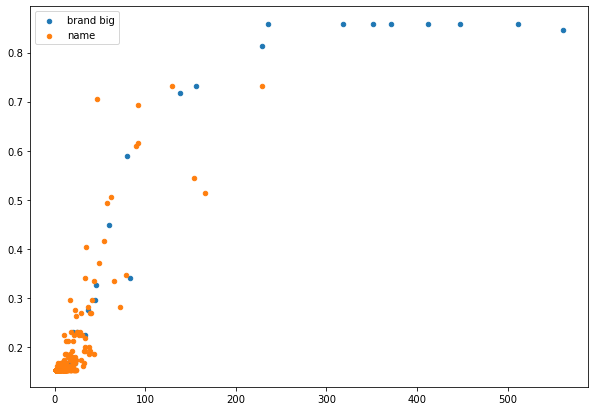

In [351]:
plt.figure(figsize=(10,7))
plt.scatter(list(abcd[association_dict_brand_big.keys()].values),association_dict_brand_big.values(),s=20,label='brand big')
plt.scatter(list(abcde[association_dict_name.keys()].values),association_dict_name.values(),s=20,label='name')
plt.legend()

In [243]:
result_cooc,result_score=cooc_mat_NAME(name_list[0],review_filtered_name)

In [245]:
result_score

{'가격': 0.15384615384615385,
 '광택': 0.15384615384615385,
 '구성': 0.15384615384615385,
 '디자인': 0.15384615384615385,
 '만족도': 0.15384615384615385,
 '맛': 0.15384615384615385,
 '성분': 0.15384615384615385,
 '용기': 0.15384615384615385,
 '트렌드': 0.15384615384615385,
 '표현': 0.15384615384615385,
 '품질': 0.15384615384615385,
 '휴대': 0.15384615384615385,
 'amore#catA# 모이스춰 플럼핑 듀이 미스트': 0.15384615384615385}

In [246]:
df['name'].value_counts()['amore#catA# 모이스춰 플럼핑 듀이 미스트']

9

In [244]:
result_cooc

,가격,광택,구성,디자인,만족도,맛,성분,용기,트렌드,표현,품질,휴대,amore#catA# 모이스춰 플럼핑 듀이 미스트
가격,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
광택,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
구성,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
디자인,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
만족도,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
맛,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
성분,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
용기,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
트렌드,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
표현,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
connectivity_tmp_name = connectivity_from_cooc(cooc_mat_name)

shape of coocurrence matrix : (292, 292)
Constructing Graph took 0.21292686462402344 secs
Calculating Connectivity took 14.753967046737671 secs


In [125]:
name_included=list(set([i[-1] for i in review_filtered_name]))

In [126]:
tmp=[]
for b in name_included:
    tmp.append(connectivity_tmp_name[b])
connectivity=tmp/max(np.array(tmp))

score3_brand=dict(zip(name_included,connectivity))

In [213]:
score3_brand

{'mamonde': 0.4268292682926829,
 'hera': 1.0,
 'hanyul': 0.3048780487804878,
 'iope': 0.23170731707317074,
 'amore': 0.23170731707317074,
 'sulhwasoo': 0.23170731707317074,
 'primera': 0.23170731707317074,
 'laneige': 0.5426829268292683}

In [214]:
score3_brand_big

{'amore#catB': 0.5757575757575758,
 'mamonde#catE': 0.5757575757575758,
 'hera#catB': 0.5757575757575758,
 'primera#catC': 0.5757575757575758,
 'mamonde#catC': 0.5757575757575758,
 'laneige#catB': 0.5757575757575758,
 'iope#catB': 0.5757575757575758,
 'iope#catE': 0.5757575757575758,
 'hera#catA': 0.5757575757575758,
 'hanyul#catB': 0.5757575757575758,
 'mamonde#catA': 1.0,
 'hanyul#catE': 0.5757575757575758,
 'laneige#catA': 0.5909090909090909,
 'sulhwasoo#catE': 0.5757575757575758,
 'hanyul#catA': 0.8787878787878788,
 'hera#catC': 0.9242424242424242,
 'primera#catA': 0.5757575757575758,
 'mamonde#catD': 0.5757575757575758,
 'hanyul#catC': 0.5757575757575758,
 'hera#catD': 0.5757575757575758,
 'primera#catE': 0.5757575757575758,
 'laneige#catC': 0.5757575757575758,
 'sulhwasoo#catA': 0.5909090909090909,
 'iope#catA': 0.5757575757575758,
 'amore#catA': 0.5757575757575758,
 'mamonde#catB': 0.5757575757575758,
 'sulhwasoo#catB': 0.5757575757575758}

# 계산하기

## brand

In [295]:
temp[temp.brand=='amore']['weight'].sum()

36

In [317]:
temp=pd.DataFrame(score1).reset_index()
temp['brand'] = temp['name'].apply(lambda x:x.split('#')[0])
temp['weight']=df.groupby('name').count().iloc[:,0].values
temp2=pd.DataFrame(temp.groupby('brand').sum()['weight']).reset_index()
temp3=pd.merge(temp,temp2, how='left', left_on='brand', right_on='brand')
temp3['weight']=temp3['weight_x']/temp3['weight_y']
temp3['S2']=temp3['S2']*temp3['weight']
temp4=temp3.groupby('brand').sum()['S2']
Score1=temp4-temp4.mean()
Score1

brand
amore        0.056732
hanyul      -0.041780
hera        -0.061419
iope         0.047827
laneige      0.008107
mamonde     -0.023182
primera      0.016902
sulhwasoo   -0.003188
Name: S2, dtype: float64

In [321]:
temp=pd.DataFrame(score2).reset_index()
temp['brand'] = temp['name'].apply(lambda x:x.split('#')[0])
temp['weight']=df.groupby('name').count().iloc[:,0].values
temp2=pd.DataFrame(temp.groupby('brand').sum()['weight']).reset_index()
temp3=pd.merge(temp,temp2, how='left', left_on='brand', right_on='brand')
temp3['weight']=temp3['weight_x']/temp3['weight_y']
temp3['S3']=temp3['S3']*temp3['weight']
temp4=temp3.groupby('brand').sum()['S3']
Score2=temp4-temp4.mean()
Score2

brand
amore        0.039208
hanyul      -0.021205
hera        -0.014093
iope         0.001239
laneige      0.006075
mamonde     -0.004429
primera     -0.001958
sulhwasoo   -0.004838
Name: S3, dtype: float64

In [322]:
Score3=pd.Series(score3_brand)
Score3=Score3.sort_index(ascending=True)

In [324]:
cbs=pd.concat([Score1,Score2,Score3],axis=1)
cbs.columns=['I','V','A']

In [325]:
cbs.to_csv('cbs.csv')

## brand+big 

In [328]:
temp=pd.DataFrame(score1).reset_index()
temp['brand'] = temp['name'].apply(lambda x:'#'.join(x.split('#')[0:2]))
temp['weight']=df.groupby('name').count().iloc[:,0].values
temp2=pd.DataFrame(temp.groupby('brand').sum()['weight']).reset_index()
temp3=pd.merge(temp,temp2, how='left', left_on='brand', right_on='brand')
temp3['weight']=temp3['weight_x']/temp3['weight_y']
temp3['S2']=temp3['S2']*temp3['weight']
temp4=temp3.groupby('brand').sum()['S2']
Score1=temp4-temp4.mean()
Score1

brand
amore#catA        0.040168
amore#catB        0.058101
hanyul#catA      -0.061004
hanyul#catB       0.073443
hanyul#catC      -0.014464
hanyul#catE      -0.046947
hera#catA        -0.010271
hera#catB        -0.091168
hera#catC        -0.129826
hera#catD        -0.013692
iope#catA         0.034957
iope#catB         0.120843
iope#catE         0.002604
laneige#catA     -0.002857
laneige#catB     -0.020902
laneige#catC      0.023187
mamonde#catA     -0.038123
mamonde#catB      0.060843
mamonde#catC     -0.003139
mamonde#catD     -0.120812
mamonde#catE      0.033636
primera#catA     -0.004527
primera#catC     -0.023407
primera#catE      0.048427
sulhwasoo#catA   -0.027417
sulhwasoo#catB    0.022501
sulhwasoo#catE    0.089843
Name: S2, dtype: float64

In [329]:
temp=pd.DataFrame(score2).reset_index()
temp['brand'] = temp['name'].apply(lambda x:'#'.join(x.split('#')[0:2]))
temp['weight']=df.groupby('name').count().iloc[:,0].values
temp2=pd.DataFrame(temp.groupby('brand').sum()['weight']).reset_index()
temp3=pd.merge(temp,temp2, how='left', left_on='brand', right_on='brand')
temp3['weight']=temp3['weight_x']/temp3['weight_y']
temp3['S3']=temp3['S3']*temp3['weight']
temp4=temp3.groupby('brand').sum()['S3']
Score2=temp4-temp4.mean()
Score2

brand
amore#catA        0.041398
amore#catB        0.045602
hanyul#catA      -0.007843
hanyul#catB       0.019337
hanyul#catC       0.028217
hanyul#catE      -0.104506
hera#catA         0.005760
hera#catB        -0.030414
hera#catC        -0.015405
hera#catD        -0.002438
iope#catA         0.029559
iope#catB         0.098571
iope#catE        -0.162131
laneige#catA      0.007203
laneige#catB      0.010091
laneige#catC      0.019103
mamonde#catA     -0.000255
mamonde#catB      0.021877
mamonde#catC      0.027317
mamonde#catD     -0.007225
mamonde#catE     -0.066127
primera#catA      0.007354
primera#catC     -0.029240
primera#catE     -0.036433
sulhwasoo#catA   -0.008429
sulhwasoo#catB    0.022181
sulhwasoo#catE    0.086877
Name: S3, dtype: float64

In [330]:
Score3=pd.Series(score3_brand_big)
Score3=Score3.sort_index(ascending=True)

In [331]:
cbs2=pd.concat([Score1,Score2,Score3],axis=1)
cbs2.columns=['I','V','A']

In [332]:
cbs2

,I,V,A
brand,,,
amore#catA,0.040168,0.041398,0.575758
amore#catB,0.058101,0.045602,0.575758
hanyul#catA,-0.061004,-0.007843,0.878788
hanyul#catB,0.073443,0.019337,0.575758
hanyul#catC,-0.014464,0.028217,0.575758
hanyul#catE,-0.046947,-0.104506,0.575758
hera#catA,-0.010271,0.005760,0.575758
hera#catB,-0.091168,-0.030414,0.575758
hera#catC,-0.129826,-0.015405,0.924242


In [333]:
cbs2.to_csv('cbs2.csv')